# Gerando Base de Dados dos Municípios de SP que elegeram um prefeito de alinhamento político diferente do segundo colocado

## Importando a Base de Prefeitos Eleitos

In [ ]:
!pip install basedosdados

     |████████████████████████████████| 88 kB 4.2 MB/s 
     |████████████████████████████████| 125 kB 24.2 MB/s 
     |████████████████████████████████| 101 kB 10.6 MB/s 
     |████████████████████████████████| 70 kB 9.1 MB/s 
     |████████████████████████████████| 9.9 MB 29.8 MB/s 
     |████████████████████████████████| 187 kB 57.6 MB/s 
     |████████████████████████████████| 75 kB 5.4 MB/s 
     |████████████████████████████████| 546 kB 41.4 MB/s 
  Attempting uninstall: google-resumable-media
    Found existing installation: google-resumable-media 0.4.1
    Uninstalling google-resumable-media-0.4.1:
      Successfully uninstalled google-resumable-media-0.4.1
  Attempting uninstall: google-cloud-core
    Found existing installation: google-cloud-core 1.0.3
    Uninstalling google-cloud-core-1.0.3:
      Successfully uninstalled google-cloud-core-1.0.3
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uni

In [ ]:
!pip install --upgrade pandas==1.2

     |████████████████████████████████| 9.9 MB 4.6 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.2.4
    Uninstalling pandas-1.2.4:
      Successfully uninstalled pandas-1.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.2.0 which is incompatible.
basedosdados 1.5.6 requires pandas==1.2.4, but you have pandas 1.2.0 which is incompatible.


- Reestartar o kernel

In [ ]:
import pandas as pd

In [ ]:
import basedosdados as bd
#Para carregar o dado direto no pandas
df = bd.read_table(dataset_id='br_tse_eleicoes', 
            table_id='resultados_candidato_municipio',
           billing_project_id="econometria-314719")

Downloading: 100%|██████████| 23308865/23308865 [00:21<00:00, 1091952.70rows/s]


In [ ]:
#df = pd.read_csv(data = "TSE_2020_SP.csv", sep = ";")

# Criando Base para RDD

## Queries Prefeitos de SP eleitos no segundo turno de 2020






In [ ]:
df_prefeitosSP = df.query("ano == 2020 & sigla_uf == 'SP' & cargo == 'prefeito'")

In [ ]:
df_prefeitosSP.shape

(2484, 12)

In [ ]:
df_prefeitosSP["id_municipio_tse"].unique().shape

(644,)

In [ ]:
df_prefeitosSP.head()

,ano,turno,tipo_eleicao,sigla_uf,id_municipio,id_municipio_tse,cargo,sigla_partido,numero_candidato,id_candidato_bd,resultado,votos
350692,2020,1,eleicao ordinaria,SP,3534757,62383,prefeito,PSDB,45,497331,nao eleito,1177
350708,2020,1,eleicao ordinaria,SP,3534906,67997,prefeito,PSB,40,126390,nao eleito,136
350730,2020,1,eleicao ordinaria,SP,3535200,68055,prefeito,PP,11,470151,nao eleito,1555
350759,2020,1,eleicao ordinaria,SP,3535507,68110,prefeito,PODE,19,524249,nao eleito,969
350760,2020,1,eleicao ordinaria,SP,3535507,68110,prefeito,REPUBLICANOS,10,797031,nao eleito,1442


In [ ]:
df_prefeitosSP.query("id_municipio_tse == '61387' | id_municipio_tse == '61298'")

,ano,turno,tipo_eleicao,sigla_uf,id_municipio,id_municipio_tse,cargo,sigla_partido,numero_candidato,id_candidato_bd,resultado,votos
16098514,2020,1,eleicao ordinaria,SP,3515129,61387,prefeito,PTB,14,111963,eleito,1186
16365806,2020,1,eleicao ordinaria,SP,3501509,61298,prefeito,PSDB,45,1727542,eleito,1447


In [ ]:
df_prefeitosSP[df_prefeitosSP["turno"] == 2].shape

(31, 12)

## Criando variável % de votos

In [ ]:
#df_prefeitosSP["total_votos"]  = df_prefeitosSP.groupby(["id_municipio_tse"]).votos.sum()

In [ ]:
total_votos2 = pd.DataFrame(df_prefeitosSP.groupby(["id_municipio_tse"]).votos.sum())

In [ ]:
df_prefeitosSP = df_prefeitosSP.merge(total_votos2, how='inner', on='id_municipio_tse')

In [ ]:
df_prefeitosSP.rename(columns = {"votos_x": "votos", "votos_y": "total_votos"}, inplace=True)

In [ ]:
df_prefeitosSP["%votos"] = (df_prefeitosSP.votos / df_prefeitosSP.total_votos).round(5)

In [ ]:
df_prefeitosSP.shape

(2484, 14)

In [ ]:
df_prefeitosSP["id_municipio_tse"].unique().shape

(644,)

## Mantendo só o 1 e o 2 colocados para cada municipio (groupby) e depois criar uma coluna da diferença percentual entre eles

### Tentando usar nlargest()

In [ ]:
grupo = pd.DataFrame(df_prefeitosSP.groupby(["id_municipio_tse"])["%votos"].nlargest(2))

In [ ]:
grupo.head()

%votos
id_municipio_tse              
61000            1797  0.72889
                 1796  0.27111
61018            2441  0.77892
                 2440  0.22108
61026            1282  0.70795

- Agora tenho que zerar o index do "Grupo"

In [ ]:
grupo = grupo.reset_index()
grupo

,id_municipio_tse,level_1,%votos
0,61000,1797,0.72889
1,61000,1796,0.27111
2,61018,2441,0.77892
3,61018,2440,0.22108
4,61026,1282,0.70795
...,...,...,...
1258,72435,772,0.22833
1259,72451,778,0.50875
1260,72451,776,0.36096
1261,72737,1041,0.51726


In [ ]:
grupo["id_municipio_tse"].unique().shape

(644,)

### Usando função .diff para subtrair uma linha pela outra 

In [ ]:
dif_votos = grupo.groupby(["id_municipio_tse"]).diff(periods=-1)
dif_votos

,level_1,%votos
0,1.0,0.45778
1,NaN,NaN
2,1.0,0.55784
3,NaN,NaN
4,-1.0,0.41590
...,...,...
1258,NaN,NaN
1259,2.0,0.14779
1260,NaN,NaN
1261,-2.0,0.11481


### Juntando com a base df_prefeitosSP

In [ ]:
dif_votos.drop(columns = "level_1", inplace = True)

In [ ]:
dif_votos.rename(columns = {"%votos": "dif_votos"}, inplace = True)

In [ ]:
grupo = grupo.join(dif_votos)

In [ ]:
grupo = grupo.drop(columns = "level_1")

In [ ]:
grupo.query("dif_votos <= 0.05")

,id_municipio_tse,%votos,dif_votos
8,61042,0.51833,0.04408
16,61085,0.38336,0.03343
22,61115,0.43730,0.02218
26,61131,0.36032,0.00292
29,61158,0.41087,0.04551
...,...,...,...
1203,71854,0.52346,0.04692
1208,71919,0.28880,0.02915
1233,72176,0.50183,0.00366
1235,72192,0.50588,0.01176


In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(grupo)

     id_municipio_tse   %votos  dif_votos
0               61000  0.72889    0.45778
1               61000  0.27111        NaN
2               61018  0.77892    0.55784
3               61018  0.22108        NaN
4               61026  0.70795    0.41590
5               61026  0.29205        NaN
6               61034  0.63166    0.26332
7               61034  0.36834        NaN
8               61042  0.51833    0.04408
9               61042  0.47425        NaN
10              61050  0.60075    0.26092
11              61050  0.33983        NaN
12              61069  0.58030    0.16060
13              61069  0.41970        NaN
14              61077  0.50068    0.06114
15              61077  0.43954        NaN
16              61085  0.38336    0.03343
17              61085  0.34993        NaN
18              61093  0.70123    0.46972
19              61093  0.23151        NaN
20              61107  0.59190    0.18380
21              61107  0.40810        NaN
22              61115  0.43730    

- Perceba que aqui o município 61387 só tem uma observação! O 61298 também. Ou seja, alguns municípios parecem que só tiveram 1 candidato! Tenho que verificar isso.
  - é isso mesmo! Vide notícia https://g1.globo.com/sp/sao-jose-do-rio-preto-aracatuba/eleicoes/2020/noticia/2020/09/30/quatro-cidades-do-noroeste-paulista-tem-apenas-um-candidato-a-prefeito.ghtml
- Se for isso, não tem problema eles serem apagados! Dado que o diferencial de votos não existiria, tornando-os inúteis para o RDD
- O problema é: Por que não estou vendo observações do 2 turno?

In [ ]:
grupo["id_municipio_tse"].unique().shape

(644,)

### Juntando com base principal (df_prefeitosSP)

In [ ]:
grupo.query('dif_votos.isnull()', engine='python')

,id_municipio_tse,%votos,dif_votos
1,61000,0.27111,NaN
3,61018,0.22108,NaN
5,61026,0.29205,NaN
7,61034,0.36834,NaN
9,61042,0.47425,NaN
...,...,...,...
1254,72397,0.29386,NaN
1256,72419,0.30382,NaN
1258,72435,0.22833,NaN
1260,72451,0.36096,NaN


In [ ]:
grupo = grupo.dropna()
grupo.shape

(619, 3)

In [ ]:
grupo = grupo.drop(columns="%votos")

In [ ]:
df_prefeitosSP = df_prefeitosSP.merge(grupo, how = "inner", on = "id_municipio_tse")

In [ ]:
df_prefeitosSP.head(5).T

,0,1,2,3,4
ano,2020,2020,2020,2020,2020
turno,1,1,1,1,1
tipo_eleicao,eleicao ordinaria,eleicao ordinaria,eleicao ordinaria,eleicao ordinaria,eleicao ordinaria
sigla_uf,SP,SP,SP,SP,SP
id_municipio,3534757,3534757,3534906,3534906,3534906
id_municipio_tse,62383,62383,67997,67997,67997
cargo,prefeito,prefeito,prefeito,prefeito,prefeito
sigla_partido,PSDB,PP,PSB,PV,PL
numero_candidato,45,11,40,43,22
id_candidato_bd,497331,620562,126390,462670,1017058


In [ ]:
df_prefeitosSP[df_prefeitosSP["turno"] == 2].shape

(31, 15)

In [ ]:
df_prefeitosSP.to_csv("df_prefeitosSP.csv", sep = ";")

### Deixar só os 2 candidatos mais votados na base principal

In [ ]:
df_prefeitosSP = df_prefeitosSP.sort_values(["%votos",'id_municipio_tse'],ascending=False).groupby('id_municipio_tse').head(2)

In [ ]:
df_prefeitosSP

,ano,turno,tipo_eleicao,sigla_uf,id_municipio,id_municipio_tse,cargo,sigla_partido,numero_candidato,id_candidato_bd,resultado,votos,total_votos,%votos,dif_votos
1940,2020,1,eleicao ordinaria,SP,3522505,65510,prefeito,PODE,19,912860,eleito,105494,106580,0.98981,0.97962
2139,2020,1,eleicao ordinaria,SP,3508108,62634,prefeito,REPUBLICANOS,10,879229,eleito,6753,6922,0.97559,0.95118
1057,2020,1,eleicao ordinaria,SP,3543006,69612,prefeito,PP,11,1542869,eleito,5914,6123,0.96587,0.93174
229,2020,1,eleicao ordinaria,SP,3542404,69493,prefeito,PSDB,45,715360,eleito,6120,6473,0.94547,0.89094
734,2020,1,eleicao ordinaria,SP,3556008,72214,prefeito,DEM,25,1582325,eleito,4563,4898,0.93160,0.87688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,2020,1,eleicao ordinaria,SP,3542404,69493,prefeito,PSB,40,613765,nao eleito,353,6473,0.05453,0.89094
1347,2020,1,eleicao ordinaria,SP,3509205,62855,prefeito,PSDB,45,494921,nao eleito,2456,46446,0.05288,0.81833
1056,2020,1,eleicao ordinaria,SP,3543006,69612,prefeito,SOLIDARIEDADE,77,920089,nao eleito,209,6123,0.03413,0.93174
2140,2020,1,eleicao ordinaria,SP,3508108,62634,prefeito,PTC,36,387472,nao eleito,169,6922,0.02441,0.95118


In [ ]:
df_prefeitosSP.query("id_municipio_tse == '62111'")

,ano,turno,tipo_eleicao,sigla_uf,id_municipio,id_municipio_tse,cargo,sigla_partido,numero_candidato,id_candidato_bd,resultado,votos,total_votos,%votos,dif_votos
1532,2020,1,eleicao ordinaria,SP,3505609,62111,prefeito,PL,22,20076,eleito,6781,18184,0.37291,0.02865
1533,2020,1,eleicao ordinaria,SP,3505609,62111,prefeito,PTB,14,313702,nao eleito,6260,18184,0.34426,0.02865


In [ ]:
df_prefeitosSP.query("turno == 2")

,ano,turno,tipo_eleicao,sigla_uf,id_municipio,id_municipio_tse,cargo,sigla_partido,numero_candidato,id_candidato_bd,resultado,votos,total_votos,%votos,dif_votos
67,2020,2,eleicao ordinaria,SP,3538709,68756,prefeito,DEM,25,569130,eleito,85081,193634,0.43939,0.30622
695,2020,2,eleicao ordinaria,SP,3554102,71838,prefeito,MDB,15,102959,eleito,92770,285733,0.32467,0.14988
274,2020,2,eleicao ordinaria,SP,3543402,69698,prefeito,PSDB,45,331578,eleito,154428,496779,0.31086,0.07791
502,2020,2,eleicao ordinaria,SP,3550308,71072,prefeito,PSDB,45,806042,eleito,3169121,10675386,0.29686,0.09377
921,2020,2,eleicao ordinaria,SP,3530607,67130,prefeito,PODE,19,900242,eleito,114656,386904,0.29634,0.08514
936,2020,2,eleicao ordinaria,SP,3518800,64777,prefeito,PSD,55,971851,eleito,327022,1126747,0.29024,0.05841
829,2020,2,eleicao ordinaria,SP,3506003,62197,prefeito,PATRIOTA,51,127342,eleito,89725,318799,0.28145,0.06013
519,2020,2,eleicao ordinaria,SP,3551009,71218,prefeito,PODE,19,993455,eleito,90876,324296,0.28023,0.06276
1064,2020,2,eleicao ordinaria,SP,3516200,64254,prefeito,MDB,15,494807,eleito,76339,276089,0.27650,0.07312
164,2020,2,eleicao ordinaria,SP,3541000,69213,prefeito,PSDB,45,1705605,eleito,75739,282875,0.26775,0.03521


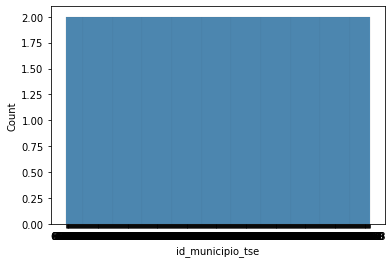

In [ ]:
import seaborn as sns

sns.histplot(df_prefeitosSP["id_municipio_tse"])

In [ ]:
df_prefeitosSP.query("turno == 1")

,ano,turno,tipo_eleicao,sigla_uf,id_municipio,id_municipio_tse,cargo,sigla_partido,numero_candidato,id_candidato_bd,resultado,votos,total_votos,%votos,dif_votos
1940,2020,1,eleicao ordinaria,SP,3522505,65510,prefeito,PODE,19,912860,eleito,105494,106580,0.98981,0.97962
2139,2020,1,eleicao ordinaria,SP,3508108,62634,prefeito,REPUBLICANOS,10,879229,eleito,6753,6922,0.97559,0.95118
1057,2020,1,eleicao ordinaria,SP,3543006,69612,prefeito,PP,11,1542869,eleito,5914,6123,0.96587,0.93174
229,2020,1,eleicao ordinaria,SP,3542404,69493,prefeito,PSDB,45,715360,eleito,6120,6473,0.94547,0.89094
734,2020,1,eleicao ordinaria,SP,3556008,72214,prefeito,DEM,25,1582325,eleito,4563,4898,0.93160,0.87688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,2020,1,eleicao ordinaria,SP,3542404,69493,prefeito,PSB,40,613765,nao eleito,353,6473,0.05453,0.89094
1347,2020,1,eleicao ordinaria,SP,3509205,62855,prefeito,PSDB,45,494921,nao eleito,2456,46446,0.05288,0.81833
1056,2020,1,eleicao ordinaria,SP,3543006,69612,prefeito,SOLIDARIEDADE,77,920089,nao eleito,209,6123,0.03413,0.93174
2140,2020,1,eleicao ordinaria,SP,3508108,62634,prefeito,PTC,36,387472,nao eleito,169,6922,0.02441,0.95118


In [ ]:
df_prefeitosSP[df_prefeitosSP["turno"] == 2] 

,ano,turno,tipo_eleicao,sigla_uf,id_municipio,id_municipio_tse,cargo,sigla_partido,numero_candidato,id_candidato_bd,resultado,votos,total_votos,%votos,dif_votos
67,2020,2,eleicao ordinaria,SP,3538709,68756,prefeito,DEM,25,569130,eleito,85081,193634,0.43939,0.30622
695,2020,2,eleicao ordinaria,SP,3554102,71838,prefeito,MDB,15,102959,eleito,92770,285733,0.32467,0.14988
274,2020,2,eleicao ordinaria,SP,3543402,69698,prefeito,PSDB,45,331578,eleito,154428,496779,0.31086,0.07791
502,2020,2,eleicao ordinaria,SP,3550308,71072,prefeito,PSDB,45,806042,eleito,3169121,10675386,0.29686,0.09377
921,2020,2,eleicao ordinaria,SP,3530607,67130,prefeito,PODE,19,900242,eleito,114656,386904,0.29634,0.08514
936,2020,2,eleicao ordinaria,SP,3518800,64777,prefeito,PSD,55,971851,eleito,327022,1126747,0.29024,0.05841
829,2020,2,eleicao ordinaria,SP,3506003,62197,prefeito,PATRIOTA,51,127342,eleito,89725,318799,0.28145,0.06013
519,2020,2,eleicao ordinaria,SP,3551009,71218,prefeito,PODE,19,993455,eleito,90876,324296,0.28023,0.06276
1064,2020,2,eleicao ordinaria,SP,3516200,64254,prefeito,MDB,15,494807,eleito,76339,276089,0.27650,0.07312
164,2020,2,eleicao ordinaria,SP,3541000,69213,prefeito,PSDB,45,1705605,eleito,75739,282875,0.26775,0.03521


## Criando Coluna "Governismo"

In [ ]:
pd.Series(df_prefeitosSP["sigla_partido"].unique()).sort_values()

15           AVANTE
9         CIDADANIA
24               DC
4               DEM
7               MDB
27             NOVO
10         PATRIOTA
14          PC do B
13              PDT
8                PL
23              PMN
0              PODE
2                PP
21             PROS
22             PRTB
11              PSB
17              PSC
6               PSD
3              PSDB
12              PSL
18             PSOL
20               PT
5               PTB
25              PTC
16               PV
26             REDE
1      REPUBLICANOS
19    SOLIDARIEDADE
dtype: object

In [ ]:
governismo = pd.read_csv("Aderencia_governista_2.csv", sep = ";")

In [ ]:
governismo 

,Partido,Aderencia,Governismo
0,AVANTE,74,1
1,CIDADANIA,87,1
2,DEM,93,1
3,MDB,91,1
4,NOVO,92,1
5,PATRIOTA,94,1
6,PC do B,29,0
7,PDT,48,0
8,PL,90,1
9,PODE,77,1


In [ ]:
governismo["Governismo"][15] = 0  # Colocando PSDB como Governismo = 0
governismo["Governismo"][15]

0

In [ ]:
governismo.rename(columns = {"Partido": "sigla_partido"}, inplace = True)

In [ ]:
df_prefeitosSP = df_prefeitosSP.merge(governismo, how = "inner", on = "sigla_partido")

In [ ]:
df_prefeitosSP.query("id_municipio_tse == '62111'")

,ano,turno,tipo_eleicao,sigla_uf,id_municipio,id_municipio_tse,cargo,sigla_partido,numero_candidato,id_candidato_bd,resultado,votos,total_votos,%votos,dif_votos,Aderencia,Governismo
638,2020,1,eleicao ordinaria,SP,3505609,62111,prefeito,PTB,14,313702,nao eleito,6260,18184,0.34426,0.02865,90,1
967,2020,1,eleicao ordinaria,SP,3505609,62111,prefeito,PL,22,20076,eleito,6781,18184,0.37291,0.02865,90,1


In [ ]:
df_prefeitosSP.groupby(["id_municipio_tse"]).sum().query("Governismo == 1 & dif_votos <= 0.10").shape

(64, 8)

### Criar Coluna "RDD" para Primeiro Turno

In [ ]:
teste = pd.DataFrame(df_prefeitosSP.groupby(["id_municipio_tse"]).Governismo.sum())

In [ ]:
#teste["id_municipio_tse"] = teste.index

In [ ]:
teste

,Governismo
id_municipio_tse,
61000,1
61018,2
61026,2
61034,1
61042,1
...,...
72397,2
72419,1
72435,1


In [ ]:
teste.rename(columns = {"Governismo": "RDD"}, inplace=True)

In [ ]:
df_prefeitosSP = df_prefeitosSP.merge(teste, how = "inner", on = "id_municipio_tse")

In [ ]:
df_prefeitosSP.query("RDD == 1").shape

(601, 18)

- Esses 289 são o que da pra usar. Ou seja, Quando o eleito era de um grupo de Governismo diferente do 2 colocado
- Não to entendendo porque vários estão com primeiro e segundo colocados como "não eleitos"

In [ ]:
df_RDD_1 = df_prefeitosSP.query("RDD == 1")

In [ ]:
df_RDD_1.head(20)

,ano,turno,tipo_eleicao,sigla_uf,id_municipio,id_municipio_tse,cargo,sigla_partido,numero_candidato,id_candidato_bd,resultado,votos,total_votos,%votos,dif_votos,Aderencia,Governismo,RDD
0,2020,1,eleicao ordinaria,SP,3522505,65510,prefeito,PODE,19,912860,eleito,105494,106580,0.98981,0.97962,77,1,1
1,2020,1,eleicao ordinaria,SP,3522505,65510,prefeito,PDT,12,712734,nao eleito,1086,106580,0.01019,0.97962,48,0,1
4,2020,1,eleicao ordinaria,SP,3520608,65137,prefeito,PODE,19,1003273,eleito,1883,3139,0.59987,0.28193,77,1,1
5,2020,1,eleicao ordinaria,SP,3520608,65137,prefeito,PSDB,45,390159,nao eleito,998,3139,0.31794,0.28193,92,0,1
12,2020,1,eleicao ordinaria,SP,3524204,65854,prefeito,PODE,19,354933,eleito,2213,4262,0.51924,0.06992,77,1,1
13,2020,1,eleicao ordinaria,SP,3524204,65854,prefeito,PSDB,45,471178,nao eleito,1915,4262,0.44932,0.06992,92,0,1
14,2020,1,eleicao ordinaria,SP,3548054,61328,prefeito,PODE,19,427508,nao eleito,2751,5781,0.47587,0.04826,77,1,1
15,2020,1,eleicao ordinaria,SP,3548054,61328,prefeito,PSDB,45,1492595,eleito,3030,5781,0.52413,0.04826,92,0,1
16,2020,1,eleicao ordinaria,SP,3550605,71137,prefeito,PODE,19,674759,eleito,17669,37663,0.46913,0.03953,77,1,1
17,2020,1,eleicao ordinaria,SP,3550605,71137,prefeito,PSDB,45,373307,nao eleito,16180,37663,0.42960,0.03953,92,0,1


In [ ]:
df_RDD_1.query("resultado == 'eleito'")

,ano,turno,tipo_eleicao,sigla_uf,id_municipio,id_municipio_tse,cargo,sigla_partido,numero_candidato,id_candidato_bd,resultado,votos,total_votos,%votos,dif_votos,Aderencia,Governismo,RDD
0,2020,1,eleicao ordinaria,SP,3522505,65510,prefeito,PODE,19,912860,eleito,105494,106580,0.98981,0.97962,77,1,1
4,2020,1,eleicao ordinaria,SP,3520608,65137,prefeito,PODE,19,1003273,eleito,1883,3139,0.59987,0.28193,77,1,1
12,2020,1,eleicao ordinaria,SP,3524204,65854,prefeito,PODE,19,354933,eleito,2213,4262,0.51924,0.06992,77,1,1
15,2020,1,eleicao ordinaria,SP,3548054,61328,prefeito,PSDB,45,1492595,eleito,3030,5781,0.52413,0.04826,92,0,1
16,2020,1,eleicao ordinaria,SP,3550605,71137,prefeito,PODE,19,674759,eleito,17669,37663,0.46913,0.03953,77,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,2020,1,eleicao ordinaria,SP,3508306,62677,prefeito,PSB,40,365220,eleito,1035,2671,0.38750,0.11008,46,0,1
1208,2020,1,eleicao ordinaria,SP,3503208,61638,prefeito,PT,13,185981,eleito,48405,105025,0.46089,0.10122,20,0,1
1214,2020,1,eleicao ordinaria,SP,3543709,69752,prefeito,PSL,17,515836,eleito,2358,5403,0.43642,0.06589,97,1,1
1216,2020,1,eleicao ordinaria,SP,3534104,67830,prefeito,PDT,12,918981,eleito,2120,3953,0.53630,0.07260,48,0,1


In [ ]:
df_RDD_1.query("resultado == 'eleito' & dif_votos <= 0.02").shape

(33, 18)

In [ ]:
df_RDD_1.to_csv("df_RDD.csv", sep = ";")

In [ ]:
df_RDD_1.to_csv("df_RDD_2.csv", sep = ";", encoding= "UTF-8")

In [ ]:
df_RDD_1.shape

(601, 18)